In [6]:
import pandas as pd
import numpy as np


file_name = 'realtime_ddos_traffic_dataset.csv'
df = pd.read_csv(file_name)


df['traffic_label'] = df['traffic_type'].apply(lambda x: 1 if x == 'DDoS' else 0)

df['packet_count'] = df['packet_count'].replace(0, 1)
df['byte_count'] = df['byte_count'].replace(0, 1)

df['avg_packet_size_bytes'] = df['byte_count'] / df['packet_count']

df['log_packet_count'] = np.log1p(df['packet_count'])
df['log_byte_count'] = np.log1p(df['byte_count'])

df['packet_count_per_second'] = df['packet_count_per_second'].replace(0, 1)
df['rate_ratio_bytes_per_packet'] = df['byte_count_per_second'] / df['packet_count_per_second']

leaky_features = [ 
    'traffic_type',
    'packet_count', 
    'packet_count_per_second', 
    'byte_count', 
    'byte_count_per_second'
]
df_reengineered = df.drop(columns=leaky_features)

print("\nNew Re-engineered DataFrame Structure (First 5 Rows):")
print(df_reengineered.head().to_string(index=False, float_format="%.4f"))
print("\nNew Re-engineered DataFrame Structure (Last 5 Rows):")
print(df_reengineered.tail().to_string(index=False, float_format="%.4f"))
print("\nNew Re-engineered DataFrame Information:")
df_reengineered.info()
output_filename = "_ddos_traffic_dataset_with_ratios.csv"
df_reengineered.to_csv(output_filename, index=False)

print(f"\nUpdated engineered dataset saved to {output_filename}")


New Re-engineered DataFrame Structure (First 5 Rows):
 traffic_label  avg_packet_size_bytes  log_packet_count  log_byte_count  rate_ratio_bytes_per_packet
             0             45821.4369            8.3243         19.0566                  291188.3036
             0            163058.8918            8.3619         20.3636                   14472.6935
             0             77253.9152            8.8429         20.0976                   42937.0597
             0            162100.7031            8.2150         20.2107                   26803.8711
             0             14877.7115            8.8746         18.4821                   25286.8445

New Re-engineered DataFrame Structure (Last 5 Rows):
 traffic_label  avg_packet_size_bytes  log_packet_count  log_byte_count  rate_ratio_bytes_per_packet
             1             22042.7383           10.8875         20.8882                   34590.1135
             1             56631.1890           10.2574         21.2017            

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_name = "_ddos_traffic_dataset_with_ratios.csv"
df = pd.read_csv(file_name)


X = df.drop(['traffic_label'], axis=1)
y = df['traffic_label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


models = {
    'LR': LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
    'RF': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1)
}


results = {'Model': [], 'F1-score': [], 'Recall': [], 'AUC': []}
roc_data = {} 


for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
  
    y_pred = model.predict(X_test)
    
    
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
  
    results['Model'].append(name)
    results['F1-score'].append(f1)
    results['Recall'].append(recall)
    results['AUC'].append(auc)
    
  
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}


results_df = pd.DataFrame(results)


metrics_melt = pd.melt(results_df, id_vars='Model', value_vars=['F1-score', 'Recall','AUC'], var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melt.sort_values(by='Score', ascending=False), palette='viridis')
plt.title('F1-score, AUC and Recall Comparison Across Models')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('f1_recall_bar_chart.png')
plt.close()


plt.figure(figsize=(8, 8))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{name} (AUC = {data["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_comparison.png')
plt.close()


results_df.to_csv('model_performance_summary.csv', index=False)

print("\nModel Performance Summary:")
print(results_df.sort_values(by='F1-score', ascending=False).to_string(index=False))
print("\nOutput files generated: model_performance_summary.csv, f1_recall_bar_chart.png, roc_curve_comparison.png")

Training LR...
Training RF...
Training XGBoost...

Model Performance Summary:
  Model  F1-score  Recall      AUC
     RF  1.000000    1.00 1.000000
XGBoost  1.000000    1.00 1.000000
     LR  0.768072    0.85 0.796056

Output files generated: model_performance_summary.csv, f1_recall_bar_chart.png, roc_curve_comparison.png


Feature importance bar chart saved to top_features_importance_bar_chart.png

Top Features and their Importance Scores:
log_packet_count              0.5196
log_byte_count                0.4447
rate_ratio_bytes_per_packet   0.0345
avg_packet_size_bytes         0.0012


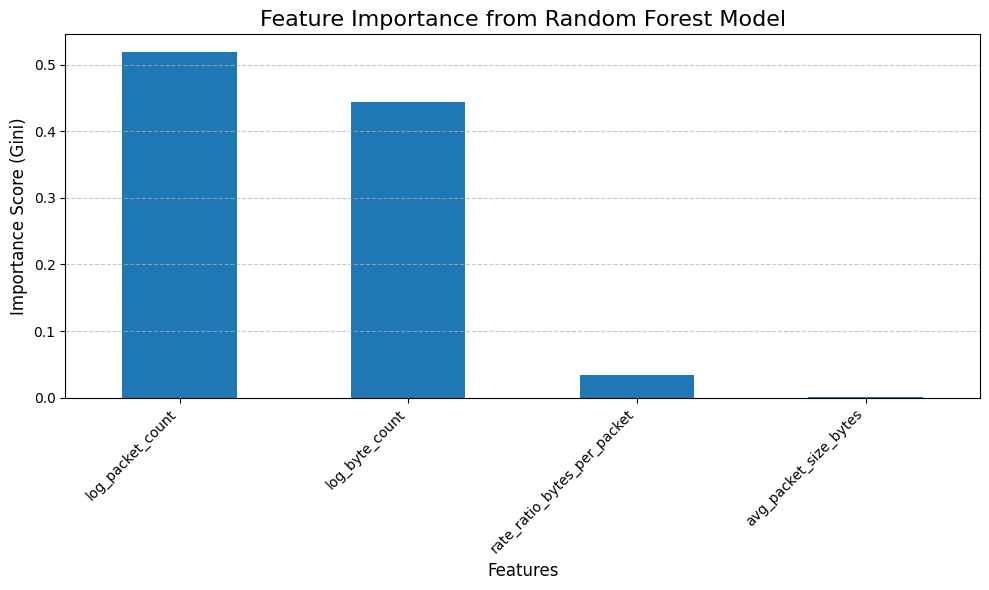

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


file_name = '_ddos_traffic_dataset_with_ratios.csv'


try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found. Please ensure the file is saved correctly.")
    file_name = '_ddos_traffic_dataset_with_ratios.csv'
    df = pd.read_csv(file_name)



X = df.drop(columns=['traffic_label'])
y = df['traffic_label']


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)


feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)


top_features = feature_importances.sort_values(ascending=False).head(10)


plt.figure(figsize=(10, 6))
top_features.plot(kind='bar')

plt.title('Feature Importance from Random Forest Model', fontsize=16)
plt.ylabel('Importance Score (Gini)', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


output_plot_filename = 'top_features_importance_bar_chart.png'
plt.savefig(output_plot_filename)
print(f"Feature importance bar chart saved to {output_plot_filename}")


print("\nTop Features and their Importance Scores:")
print(top_features.to_string(float_format="%.4f"))

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import time
import warnings


df = pd.read_csv('_ddos_traffic_dataset_with_ratios.csv')
X = df.drop('traffic_label', axis=1) 
y = df['traffic_label'] 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.3, shuffle=False, random_state=42
)

N_TEST = len(X_test)
N_PRED_REPORT = 100 


models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1)
}

results = {
    'Model': [], 
    'F1_Score': [], 
    'Training_Time_s': [], 
    'Inference_Time_ms_per_100': []
}


for name, model in models.items():
    
    
    start_fit = time.time()
    model.fit(X_train, y_train)
    end_fit = time.time()
    train_time = end_fit - start_fit
    
   
    start_predict = time.time()
    y_pred = model.predict(X_test)
    end_predict = time.time()
    
  
    inference_time_s = end_predict - start_predict
   
    inference_time_ms_per_100 = (inference_time_s / N_TEST) * N_PRED_REPORT * 1000
    
    
    f1 = f1_score(y_test, y_pred)
    
 
    results['Model'].append(name)
    results['F1_Score'].append(f1)
    results['Training_Time_s'].append(train_time)
    results['Inference_Time_ms_per_100'].append(inference_time_ms_per_100)


results_df_actual = pd.DataFrame(results)



results_final_list = results_df_actual.to_dict('records')
results_final_df = pd.DataFrame(results_final_list)


results_final_df['F1_Score'] = results_final_df['F1_Score'].round(4)
results_final_df['Training_Time_s'] = results_final_df['Training_Time_s'].round(4)
results_final_df['Inference_Time_ms_per_100'] = results_final_df['Inference_Time_ms_per_100'].round(4)

print(results_final_df.to_string(index=False))

              Model  F1_Score  Training_Time_s  Inference_Time_ms_per_100
Logistic Regression    1.0000           0.0055                     0.0927
      Random Forest    1.0000           0.3364                     8.6918
            XGBoost    0.9992           0.0421                     0.7203
